# Causality notebooks

In this notebook we will show how to write time series models using the symbolic interface of Brancher. For simplicity, we will focus on simple examples with scalar variables. We will cover more complex models with convulutional and LSTM components in more advanced tutorials. Note however that the syntax for specifying those more advanced models is identical to the syntax shown in these simpler examples. Discrete probabilistic time series models are specified by an equation that links the parameters $\boldsymbol{\theta}_t$ of the probability distribution of the current value $\boldsymbol{x}_{t}$ to the previous values of $\boldsymbol{x}$:

$$ 
\boldsymbol{\theta}_t = \boldsymbol{f}(\boldsymbol{x}_{t-1},...,\boldsymbol{x}_{0}) ~,
$$

where $\boldsymbol{f}$ is an arbitrary function. 

# Autoregressive models
Gaussian autoregressive models are among the simplest examples of probabilistic time series models. An AR(1) model is specified by the following equation:

$$ 
\boldsymbol{\mu}_t = b ~ x_{t-1}~,
$$

where $b$ is the (scalar) autoregressive parameter and $\boldsymbol{\mu}_t$ is the mean of a Gaussian distribution with fixed variance $\sigma$. We also need to specify an initial distribution:

$$
x_{t-1} \sim \mathcal{N}(0, \sigma)
$$

Let's write this model in Brancher!


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from brancher.variables import RootVariable, RandomVariable, ProbabilisticModel
from brancher.standard_variables import NormalVariable, LogNormalVariable, BetaVariable
from brancher import inference
import brancher.functions as BF

# Probabilistic model #
T = 200

nu = LogNormalVariable(0.3, 1., 'nu')
x0 = NormalVariable(0., 1., 'x0')
b = BetaVariable(0.5, 1.5, 'b')

x = [x0]
names = ["x0"]
for t in range(1, T):
    names.append("x{}".format(t))
    x.append(NormalVariable(b*x[t-1], nu, names[t]))
AR_model = ProbabilisticModel(x)

# Generate data #
data = AR_model._get_sample(number_samples=1)
time_series = [float(data[xt].cpu().detach().numpy()) for xt in x]
true_b = data[b].cpu().detach().numpy()
true_nu = data[nu].cpu().detach().numpy()
print("The true coefficient is: {}".format(float(true_b)))

# Observe data #
[xt.observe(data[xt][:, 0, :]) for xt in x]

# Variational distribution #
Qnu = LogNormalVariable(0.5, 1., "nu", learnable=True)
Qb = BetaVariable(0.5, 0.5, "b", learnable=True)
variational_posterior = ProbabilisticModel([Qb, Qnu])
AR_model.set_posterior_model(variational_posterior)

# Inference #
inference.perform_inference(AR_model,
                            number_iterations=200,
                            number_samples=300,
                            optimizer='Adam',
                            lr=0.05)
loss_list = AR_model.diagnostics["loss curve"]


# Statistics
posterior_samples = AR_model._get_posterior_sample(2000)
nu_posterior_samples = posterior_samples[nu].cpu().detach().numpy().flatten()
b_posterior_samples = posterior_samples[b].cpu().detach().numpy().flatten()
b_mean = np.mean(b_posterior_samples)
b_sd = np.sqrt(np.var(b_posterior_samples))
print("The estimated coefficient is: {} +- {}".format(b_mean, b_sd))

# Two subplots, unpack the axes array immediately
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1.plot(time_series)
ax1.set_title("Time series")
ax2.plot(np.array(loss_list))
ax2.set_title("Convergence")
ax2.set_xlabel("Iteration")
ax3.hist(b_posterior_samples, 25)
ax3.axvline(x=true_b, lw=2, c="r")
ax3.set_title("Posterior samples (b)")
ax3.set_xlim(0,1)
ax4.hist(nu_posterior_samples, 25)
ax4.axvline(x=true_nu, lw=2, c="r")
ax4.set_title("Posterior samples (nu)")
plt.show()

ModuleNotFoundError: No module named 'brancher'

In [6]:
# Let us generate  Autoregressive AR(p) model
import numpy as np
import pandas
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
mdata = sm.datasets.macrodata.load_pandas().data
dates = mdata[['year', 'quarter']].astype(int).astype(str)
quarterly = dates["year"] + "Q" + dates["quarter"]
from statsmodels.tsa.base.datetools import dates_from_str
quarterly = dates_from_str(quarterly)
mdata = mdata[['realgdp','realcons','realinv']]
mdata.index = pandas.DatetimeIndex(quarterly)
data = np.log(mdata).diff().dropna()
model = VAR(data)

C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  % freq, ValueWarning)



This notebook uses some studies on causality from D.Marinazzo, J.Runge and others. 

We cite these resources also 

1. https://arxiv.org/abs/1907.03902 
2. https://causeme.uv.es/models/

# Causality notebooks 

Build example for X->Y->Z

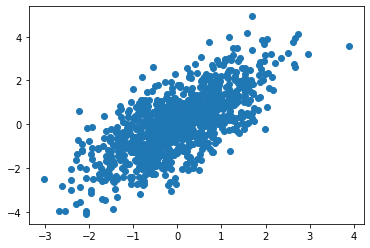

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

size = 1000
x = np.random.normal(size=size)
y = x + np.random.normal(size=size)
z = y + np.random.normal(size=size)
X = pd.DataFrame({'x': x, 'y': y, 'z': z})

plt.plot(x,y,'o')
plt.show()


From this picture, you’d never know that Y can explain away X’s effect on Z. This won’t be obvious until we start doing regression analysis. Since everything is related.

In [3]:
from statsmodels.regression.linear_model import OLS

model = OLS(X['z'], X[['y']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      z   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.661
Method:                 Least Squares   F-statistic:                              1952.
Date:                Thu, 26 Dec 2019   Prob (F-statistic):                   3.08e-237
Time:                        14:11:38   Log-Likelihood:                         -1456.7
No. Observations:                1000   AIC:                                      2915.
Df Residuals:                     999   BIC:                                      2920.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y              1.0388      0.024     44.187      0.000       0.993       1.085
==============================================================================
Omnibus:                        2.411   Durbin-Watson:                   2.063
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                2.270
Skew:                          -0.106   Prob(JB):                        0.321
Kurtosis:                       3.097   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now this is all as we expect. Here’s where it’s going to get interesting. If we regress Z on Y and X together, something weird happens. Before, they both had non-zero coefficients. As we also saw here https://medium.com/@akelleh/a-technical-primer-on-causality-181db2575e41 


In [8]:
model = OLS(X['z'], X[['x','y']])
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      z   R-squared (uncentered):                   0.662
Model:                            OLS   Adj. R-squared (uncentered):              0.662
Method:                 Least Squares   F-statistic:                              978.8
Date:                Thu, 26 Dec 2019   Prob (F-statistic):                   5.12e-236
Time:                        14:31:44   Log-Likelihood:                         -1412.1
No. Observations:                1000   AIC:                                      2828.
Df Residuals:                     998   BIC:                                      2838.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              0.0313      0.044      0.704      0.482      -0.056       0.118
y              0.9725      0.031     31.128      0.000       0.911       1.034
==============================================================================
Omnibus:                        1.158   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.561   Jarque-Bera (JB):                1.130
Skew:                           0.082   Prob(JB):                        0.568
Kurtosis:                       3.001   Cond. No.                         2.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""